In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
import cv2
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc 
from functools import reduce
import wfdb#https://github.com/MIT-LCP/wfdb-python
from wfdb import processing
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.cuda.set_device(1)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


1


In [2]:
#Read data with List storage Name:[name],I:[img],Y[type]
def TypetoNum(itype): #map the type into number.
    if itype =='AMD': return 0
    elif itype =='DR': return 1
    elif itype =='glaucoma': return 2
    elif itype =='myopia': return 3
    else: return 4 #norm
    
root_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/' #the path of images
trainset = pd.read_csv("/data/fjsdata/fundus/iSee/iSee_multi_dataset/CBIR_iSee_train.csv" , sep=',')#load trainset
testset = pd.read_csv("/data/fjsdata/fundus/iSee/iSee_multi_dataset/CBIR_iSee_test.csv" , sep=',')#load testset
tstart = time.time()
#read train image with CV
trN, trI, trY = [],[],[]
norm = 6993
for iname, itype in np.array(trainset).tolist():
    if iname.endswith(".jpg"):
        try:
            image_dir = root_dir+'img_data_%s'%itype
            image_path = os.path.join(image_dir, iname)
            if itype == 'norm':
                if norm>0:
                    img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(1920,1920,3)->(256,256,3)
                    trN.append(iname)
                    trI.append(img)
                    trY.append(TypetoNum(itype))
                    norm = norm - 1
            else:
                img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(1920,1920,3)->(256,256,3)
                trN.append(iname)
                trI.append(img)
                trY.append(TypetoNum(itype))    
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(trN),trainset.shape[0]))
        sys.stdout.flush()
print('The length of train set is %d'%len(trN))
#read test image with CV
teN, teI, teY = [],[],[]
norm = 777
for iname, itype in np.array(testset).tolist():
    if iname.endswith(".jpg"):
        try:
            image_dir = root_dir+'img_data_%s'%itype
            image_path = os.path.join(image_dir, iname)
            if itype == 'norm':
                if norm>0:
                    img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(1920,1920,3)->(256,256,3)
                    teN.append(iname)
                    teI.append(img)
                    teY.append(TypetoNum(itype))
                    norm = norm - 1
            else:
                img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(1920,1920,3)->(256,256,3)
                teN.append(iname)
                teI.append(img)
                teY.append(TypetoNum(itype)) 
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(teN),testset.shape[0]))
        sys.stdout.flush()
print('The length of test set is %d'%len(teN))
elapsed = time.time() - tstart    
print('Completed data handle in %d seconds' % int(elapsed))

9000 / 9000 The length of train set is 9000
1000 / 1000 The length of test set is 1000
Completed data handle in 773 seconds


In [5]:
#ATH model with Tripet loss
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.linear = nn.Linear(1*32*32, code_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        return x

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#https://github.com/luyajie/triplet-deep-hash-pytorch#triplet-deep-hash-pytorch            
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self,H_q,H_p,H_n):    
        margin_val = self.margin * H_q.shape[1]
        squared_loss_pos = torch.mean(self.mse_loss(H_q, H_p), dim=1)
        squared_loss_neg = torch.mean(self.mse_loss(H_q, H_n), dim=1)
        zeros = torch.zeros_like(squared_loss_neg)
        loss  = torch.max(zeros, margin_val - squared_loss_neg + squared_loss_pos)
        return torch.mean(loss)

#Generate image pairs for model
def onlineGenImgPairs( ):
    idx_sf = []
    idx_0 = np.where( np.array(trY) == 0 ) #class 0
    idx_0 = list(idx_0[0])
    idx_sf.extend(idx_0)
    idx_1 = np.where( np.array(trY) == 1 ) #class 1
    idx_1 = list(idx_1[0])
    idx_sf.extend(idx_1)
    idx_2 = np.where( np.array(trY) == 2 ) #class 2
    idx_2 = list(idx_2[0])
    idx_sf.extend(idx_2)
    idx_3 = np.where( np.array(trY) == 3 ) #class 3
    idx_3 = list(idx_3[0])
    idx_sf.extend(idx_3)
    idx_4 = np.where( np.array(trY) == 4 ) #class 4
    idx_4 = list(idx_4[0])
    idx_sf.extend(idx_4)
    random.shuffle(idx_sf)   
    trQ_sf, trP_sf, trN_sf = [], [], []
    for iQ in idx_sf:
        trQ_sf.append(trI[iQ])
        if trY[iQ] == 0:
            idx_tmp = idx_0.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_0))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 1:
            idx_tmp = idx_1.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_1))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 2:
            idx_tmp = idx_2.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_2))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 3:
            idx_tmp = idx_3.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_3))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 4:
            idx_tmp = idx_4.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_4))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        else: pass
        sys.stdout.write('\r{} / {} '.format(len(trQ_sf),len(idx_sf)))
        sys.stdout.flush()
    return np.array(trQ_sf),np.array(trP_sf),np.array(trN_sf)
trQ_sf, trP_sf, trN_sf = onlineGenImgPairs() #sample 
assert (trQ_sf.shape==trP_sf.shape)
assert (trQ_sf.shape==trN_sf.shape)

#define model
model = ATHNet(code_size=36).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = TripletLoss(margin=0.5).cuda() #define TripletLoss 
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    train_q = trQ_sf[shuffled_idx]
    train_p = trP_sf[shuffled_idx]
    train_n = trN_sf[shuffled_idx]
    num_batches = len(trQ_sf) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(train_q[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_batch = torch.from_numpy(train_p[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_batch = torch.from_numpy(train_n[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        Q_hash = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_hash = model(P_batch.permute(0, 3, 1, 2))
        N_hash = model(N_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(Q_hash,P_hash,N_hash)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
criterion=criterion.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        scores, neighbors = gpu_index.search(np.array(teF)[i:i+1].astype('float32'), k=topk)
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors.flatten():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
    
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teF, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels ) #labels=['AMD','DR','glaucoma','myopia','norm']
print (cm)
print ('Specificity of normal: %.6f'%float(cm[4][4]/np.sum(cm[4])))
print ('Sensitivity of AMD: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of DR: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of glaucoma: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of myopia: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 900 / 900 : loss = 20.701817Eopch:     1 mean_loss = 17.098784
 900 / 900 : loss = 16.607653Eopch:     2 mean_loss = 16.167664
 900 / 900 : loss = 15.191724Eopch:     3 mean_loss = 15.619937
 900 / 900 : loss = 16.948387Eopch:     4 mean_loss = 14.689277
 900 / 900 : loss = 14.159218Eopch:     5 mean_loss = 13.306673
 900 / 900 : loss = 11.576347Eopch:     6 mean_loss = 11.370548
 900 / 900 : loss = 0.1148246Eopch:     7 mean_loss = 9.443250
 900 / 900 : loss = 9.8200762Eopch:     8 mean_loss = 7.888464
 900 / 900 : loss = 8.8942259Eopch:     9 mean_loss = 6.407361
 900 / 900 : loss = 5.4244741Eopch:    10 mean_loss = 5.439723
best_loss = 5.439723
 99 / 100  Completed buliding index in 23 seconds
mHR@10=0.737400, mAP@10=0.687811, mRR@10=0.901891
Accuracy: 0.746000
[[  3   1   7   4  57]
 [  3   0   0   1  23]
 [  4   2   1   2  36]
 [ 11   2   3  21  42]
 [ 24   6  15  11 721]]
Specificity of normal: 0.927928
Sensitivity of AMD: 0.041667
Sensitivity of DR: 0.000000
Sensitivity of glau

In [7]:
#ATH model with pairwise loss
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.linear = nn.Linear(1*32*32, code_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        return x

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#define loss function:pairwise loss            
class PairwiseLoss(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(PairwiseLoss, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss

#Generate image pairs for model
def onlineGenImgPairs():
    if (len(trY) % 2) == 0: spls = len(trY)
    else:  spls = len(trY)-1
    idx_sf = random.sample(range(0, spls),spls)
    trI1_sf, trI2_sf, trY1_sf, trY2_sf = [],[],[],[]
    flag = 0
    for i in idx_sf:
        if flag==0:
            trI1_sf.append(trI[i])
            trY1_sf.append(trY[i])
            flag =1
        else:
            trI2_sf.append(trI[i])
            trY2_sf.append(trY[i])
            flag =0
    trY_sf = np.where((np.array(trY1_sf)-np.array(trY2_sf))!=0,1,0)
    return np.array(trI1_sf),np.array(trI2_sf),trY_sf

#define model
model = ATHNet(code_size=36).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = PairwiseLoss(margin=0.5).cuda() #define PairwiseLoss 
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs()
    losses = []
    num_batches = len(trY_sf) // batchSize 
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
criterion=criterion.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        scores, neighbors = gpu_index.search(np.array(teF)[i:i+1].astype('float32'), k=topk)
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors.flatten():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teF, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels ) #labels=['AMD','DR','glaucoma','myopia','norm']
print (cm)
print ('Specificity of normal: %.6f'%float(cm[4][4]/np.sum(cm[4])))
print ('Sensitivity of AMD: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of DR: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of glaucoma: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of myopia: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 450 / 450 : loss = 4.460619Eopch:     1 mean_loss = 3.497393
 450 / 450 : loss = 2.862026Eopch:     2 mean_loss = 3.465407
 450 / 450 : loss = 2.963078Eopch:     3 mean_loss = 3.309732
 450 / 450 : loss = 4.067571Eopch:     4 mean_loss = 3.270898
 450 / 450 : loss = 2.703939Eopch:     5 mean_loss = 3.300474
 450 / 450 : loss = 2.101919Eopch:     6 mean_loss = 3.264904
 450 / 450 : loss = 1.802994Eopch:     7 mean_loss = 3.199393
 450 / 450 : loss = 3.393795Eopch:     8 mean_loss = 3.324095
 450 / 450 : loss = 2.944171Eopch:     9 mean_loss = 3.202616
 450 / 450 : loss = 4.130229Eopch:    10 mean_loss = 3.286979
best_loss = 3.199393
 99 / 100  Completed buliding index in 1 seconds
mHR@10=0.640900, mAP@10=0.540794, mRR@10=0.828881
Accuracy: 0.661000
[[ 13   1   4   2  52]
 [  1   2   1   0  23]
 [  8   2   0   2  33]
 [  3   1   5  22  48]
 [ 57  22  28  46 624]]
Specificity of normal: 0.803089
Sensitivity of AMD: 0.180556
Sensitivity of DR: 0.074074
Sensitivity of glaucoma: 0.000000
Se

In [12]:
#ATH model with focal loss
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, class_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.linear = nn.Linear(1*32*32, class_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        out = self.linear(x)
        return x,out

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#https://github.com/marvis/pytorch-yolo2/blob/master/FocalLoss.py
#https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py
class FocalLoss(nn.Module):
    #Loss(x, class) = - \alpha (1-softmax(x)[class])^gamma \log(softmax(x)[class])
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, out, y):
        y = y.view(-1,1)
        logpt = F.log_softmax(out,dim=1)#default ,dim=1
        logpt = logpt.gather(1,y)# dim=1, index=y, max
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=out.data.type():
                self.alpha = self.alpha.type_as(out.data)
            at = self.alpha.gather(0,y.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()
        
#define model
model = ATHNet(class_size=5).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = FocalLoss(gamma=2,alpha=[0.2,0.4,0.2,0.15,0.05]).cuda() #define ce mutli-classes, 
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
trI = np.array(trI)
trY = np.array(trY)
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trY)))
    train_x = trI[shuffled_idx]
    train_y = trY[shuffled_idx]
    num_batches = len(trY) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        x_batch = torch.from_numpy(train_x[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(train_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        _, out_batch = model(x_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        loss = criterion(out_batch,y_batch) #F.log_softmax+F.nll_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
criterion = criterion.cpu()
torch.cuda.empty_cache()
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    feature, _ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    feature = feature.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(feature.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

teY_pred = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    feature, out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(feature.cpu().data.numpy().tolist()) #record feature
    out_batch = F.log_softmax(out_batch,dim=1) 
    pred = out_batch.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(32*32) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        scores, neighbors = gpu_index.search(np.array(teF)[i:i+1].astype('float32'), k=topk)
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors.flatten():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

#confusion matrix
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels ) #labels=['AMD','DR','glaucoma','myopia','norm']
print (cm)
print ('Specificity of normal: %.6f'%float(cm[4][4]/np.sum(cm[4])))
print ('Sensitivity of AMD: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of DR: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of glaucoma: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of myopia: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 900 / 900 : loss = 0.025827Eopch:     1 mean_loss = 0.075194
 900 / 900 : loss = 0.067827Eopch:     2 mean_loss = 0.071478
 900 / 900 : loss = 0.085572Eopch:     3 mean_loss = 0.069584
 900 / 900 : loss = 0.085841Eopch:     4 mean_loss = 0.066611
 900 / 900 : loss = 0.130229Eopch:     5 mean_loss = 0.063935
 900 / 900 : loss = 0.015422Eopch:     6 mean_loss = 0.061875
 900 / 900 : loss = 0.115747Eopch:     7 mean_loss = 0.060433
 900 / 900 : loss = 0.078121Eopch:     8 mean_loss = 0.058288
 900 / 900 : loss = 0.023583Eopch:     9 mean_loss = 0.056304
 900 / 900 : loss = 0.131926Eopch:    10 mean_loss = 0.054898
best_loss = 0.054898
 99 / 100  Completed buliding index in 2 seconds
mHR@10=0.639300, mAP@10=0.541441, mRR@10=0.829425
Accuracy: 0.715000
[[ 11   0   3   6  52]
 [  2   0   0   3  22]
 [  3   2   7   2  31]
 [ 11   0   3  30  35]
 [ 46   7  29  28 667]]
Specificity of normal: 0.858430
Sensitivity of AMD: 0.152778
Sensitivity of DR: 0.000000
Sensitivity of glaucoma: 0.155556
Se

In [14]:
#ATH model with cross entropy loss
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, class_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.linear = nn.Linear(1*32*32, class_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        out = self.linear(x)
        return x,out

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#define model
model = ATHNet(class_size=5).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = nn.CrossEntropyLoss().cuda() #define ce mutli-classes
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
trI = np.array(trI)
trY = np.array(trY)
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trY)))
    train_x = trI[shuffled_idx]
    train_y = trY[shuffled_idx]
    num_batches = len(trY) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        x_batch = torch.from_numpy(train_x[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(train_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        _,out_batch = model(x_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        loss = criterion(out_batch,y_batch) #F.log_softmax+F.nll_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
criterion = criterion.cpu()
torch.cuda.empty_cache()
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    feature, _ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    feature = feature.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(feature.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

teY_pred = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    feature, out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(feature.cpu().data.numpy().tolist()) #record feature
    out_batch = F.log_softmax(out_batch,dim=1) 
    pred = out_batch.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(32*32) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        scores, neighbors = gpu_index.search(np.array(teF)[i:i+1].astype('float32'), k=topk)
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors.flatten():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#confusion matrix
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels ) #labels=['AMD','DR','glaucoma','myopia','norm']
print (cm)
print ('Specificity of normal: %.6f'%float(cm[4][4]/np.sum(cm[4])))
print ('Sensitivity of AMD: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of DR: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of glaucoma: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of myopia: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 900 / 900 : loss = 0.473502Eopch:     1 mean_loss = 0.818080
 900 / 900 : loss = 0.604596Eopch:     2 mean_loss = 0.773206
 900 / 900 : loss = 0.412981Eopch:     3 mean_loss = 0.760208
 900 / 900 : loss = 1.241025Eopch:     4 mean_loss = 0.750548
 900 / 900 : loss = 0.338364Eopch:     5 mean_loss = 0.748032
 900 / 900 : loss = 1.065161Eopch:     6 mean_loss = 0.740972
 900 / 900 : loss = 0.696076Eopch:     7 mean_loss = 0.732908
 900 / 900 : loss = 1.295812Eopch:     8 mean_loss = 0.726191
 900 / 900 : loss = 1.512881Eopch:     9 mean_loss = 0.720169
 900 / 900 : loss = 1.168957Eopch:    10 mean_loss = 0.715275
best_loss = 0.715275
 99 / 100  Completed buliding index in 2 seconds
mHR@10=0.655800, mAP@10=0.569686, mRR@10=0.844168
Accuracy: 0.783000
[[  0   0   0   3  69]
 [  0   0   0   2  25]
 [  0   0   0   1  44]
 [  0   0   0  13  66]
 [  0   0   0   7 770]]
Specificity of normal: 0.990991
Sensitivity of AMD: 0.000000
Sensitivity of DR: 0.000000
Sensitivity of glaucoma: 0.000000
Se

Org data dimension is 1024.Embedded data dimension is 2


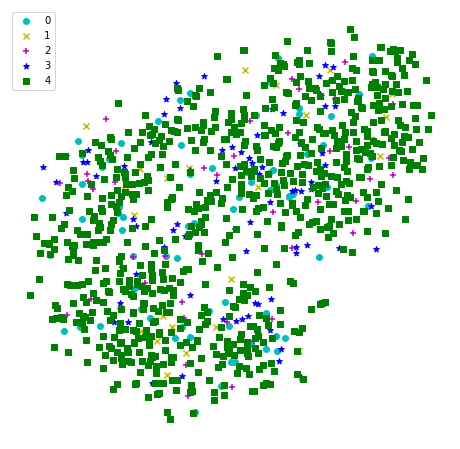

In [6]:
#visualize : t-SNE
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import random
def scatter(X, y):
    #X,y:numpy-array
    classes = len(list(set(y.tolist())))#get number of classes
    #palette = np.array(sns.color_palette("hls", classes))# choose a color palette with seaborn.
    color = ['c','y','m','b','g','r']
    marker = ['o','x','+','*','s']
    plt.figure(figsize=(8,8))#create a plot
    for i in range(classes):
        plt.scatter(X[y == i,0], X[y == i,1], c=color[i], marker=marker[i], label=str(i))
    plt.axis('off')
    plt.legend(loc='upper left')
    #plt.savefig('digits_tsne-generated.png', dpi=100)
    plt.show()

#prepare data，classes=5
#idx= random.sample(np.where(np.array(teY)==0)[0].tolist(),100)
idx= np.where(np.array(teY)==0)[0].tolist()
X0= np.array(teF)[idx]
y0= np.array(teY)[idx]

idx= np.where(np.array(teY)==1)[0].tolist()
X1= np.array(teF)[idx]
y1= np.array(teY)[idx]

idx= np.where(np.array(teY)==2)[0].tolist()
X2= np.array(teF)[idx]
y2= np.array(teY)[idx]

idx= np.where(np.array(teY)==3)[0].tolist()
X3= np.array(teF)[idx]
y3= np.array(teY)[idx]

idx= np.where(np.array(teY)==4)[0].tolist()
X4= np.array(teF)[idx]
y4= np.array(teY)[idx]

y = np.append(y0,y1)
y = np.append(y,y2)
y = np.append(y,y3)
y = np.append(y,y4)
X = np.vstack((X0,X1))
X = np.vstack((X,X2))
X = np.vstack((X,X3))
X = np.vstack((X,X4))
#training t-sne 
tsne = TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}.Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

#visualize
scatter(X_tsne, y)

In [7]:
# generate class activation mapping for the top1 prediction
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    
    output_cam = []
    for idx in class_idx:
        #cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc,h*w)))
        cam = weight_softmax[class_idx]*(feature_conv.reshape((nc,h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
#last conv layer followed with one channel by last fully connected layer
final_conv = 'dense' 
best_net._modules.get(final_conv).register_forward_hook(hook_feature)
#get weights parameters
params = list(best_net.parameters())
#get the last and second last weights, like [classes, hiden nodes]
weight_softmax = np.squeeze(params[-2].data.cpu().numpy()) 
# define class type
classes = {0: 'AMD', 1: 'DR', 2:'glaucoma', 3:'myopia', 4:'norm'}
#read image
root='/data/fjsdata/fundus/iSee/iSee_multi_dataset/img_data_AMD/99971.jpg'
img = []
img.append( cv2.resize(cv2.imread(root).astype(np.float32), (256, 256)))#(256, 256) is the model input size
data = torch.from_numpy(np.array(img)).type(torch.FloatTensor).cuda()
_,logit = best_net(data.permute(0, 3, 1, 2))#forword
h_x = F.softmax(logit, dim=1).data.squeeze()#softmax
probs, idx = h_x.sort(0, True) #probabilities of classes

# output: the prediction
for i in range(0, len(classes)):
    line = '{:.3f} -> {}'.format(probs[i], classes[idx[i].item()])
    print(line)
#get the class activation maps
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0].item()])

# render the CAM and show
print('output CAM.jpg for the top1 prediction: %s' % classes[idx[0].item()])
img = cv2.imread(root)
height, width, _ = img.shape
CAM = cv2.resize(CAMs[0], (width, height))
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('iSee_cam.jpg', result)

0.855 -> norm
0.070 -> AMD
0.045 -> glaucoma
0.018 -> DR
0.012 -> myopia
output CAM.jpg for the top1 prediction: norm


True

In [11]:
print (best_net._modules.items())

odict_items([('net1', Sequential(
  (0): ResBlock(
    (net): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (downsample_layer): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
)), ('sa', SpatialAttention(
  (conv1): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sigmoid): Sigmoid()
)), ('net2', Sequential(
  (0): ResBlock(
    (net): Sequential(
      (0): Conv2d(16, 8, 